# 국민대-Air Korea 측정소별 마할노비스 미세먼지 교정 알고리즘

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')
plt.rcParams['figure.figsize'] = [10, 8]

## 1-Air Korea 전처리

In [2]:
air_df = pd.read_csv('./airkorea_201127.csv', encoding='euc-kr')
air_df.head()

,no,city,gu,pm10,pm25,no2,co,so2,o3,reg_date
0,386158,제주,성산읍,18,10,0.007,0.1,0.001,0.034,2020-11-27 11:13:38.959746
1,386156,제주,남원읍,22,10,0.005,0.2,0.001,0.034,2020-11-27 11:13:38.959103
2,386155,제주,이도동,24,12,0.011,0.3,0.001,0.033,2020-11-27 11:13:38.95881
3,386154,제주,대정읍,23,9,0.004,0.0,0.001,0.037,2020-11-27 11:13:38.958518
4,386153,제주,연동,27,13,0.010,0.1,0.002,0.034,2020-11-27 11:13:38.958224


In [3]:
air_df = air_df[air_df.city == '서울']
air_df = air_df[air_df.gu.isin([
    '도봉구', '강북구', '노원구',
    '성북구', '종로구', '서대문구', '중랑구',
    '중구', '성동구', '광진구', '청계천로', '홍릉로'
])]
air_df.head()

,no,city,gu,pm10,pm25,no2,co,so2,o3,reg_date
422,385682,서울,청계천로,53,41,0.029,0.8,0.005,0.012,2020-11-27 11:13:38.754998
423,385681,서울,중구,56,33,0.025,0.5,0.004,0.015,2020-11-27 11:13:38.754724
426,385678,서울,강북구,37,22,0.011,0.4,0.004,0.021,2020-11-27 11:13:38.753734
428,385676,서울,성북구,38,23,0.025,0.5,0.003,0.015,2020-11-27 11:13:38.751319
433,385671,서울,성동구,41,29,0.035,0.5,0.004,0.015,2020-11-27 11:13:38.749837


In [4]:
air_df.reg_date = pd.to_datetime(air_df.reg_date)
air_df.loc[:, 'reg_date_hour'] = air_df.reg_date.dt.strftime('%Y%m%d%H')
air_df.head()

,no,city,gu,pm10,pm25,no2,co,so2,o3,reg_date,reg_date_hour
422,385682,서울,청계천로,53,41,0.029,0.8,0.005,0.012,2020-11-27 11:13:38.754998,2020112711
423,385681,서울,중구,56,33,0.025,0.5,0.004,0.015,2020-11-27 11:13:38.754724,2020112711
426,385678,서울,강북구,37,22,0.011,0.4,0.004,0.021,2020-11-27 11:13:38.753734,2020112711
428,385676,서울,성북구,38,23,0.025,0.5,0.003,0.015,2020-11-27 11:13:38.751319,2020112711
433,385671,서울,성동구,41,29,0.035,0.5,0.004,0.015,2020-11-27 11:13:38.749837,2020112711


In [5]:
# Moving Average 파생변수, window=24(24hours) 이동평균 간격
air_df['pm25_air_ma'] = air_df.pm25.rolling(window=24).mean()
air_df['pm10_air_ma'] = air_df.pm10.rolling(window=24).mean()

In [6]:
air_pivot = air_df.pivot(index='reg_date_hour', columns='gu', values='pm25_air_ma')
air_pivot.head()

gu,강북구,광진구,노원구,도봉구,서대문구,성동구,성북구,종로구,중구,중랑구,청계천로,홍릉로
reg_date_hour,,,,,,,,,,,,
2020101423,12.125000,12.458333,11.958333,12.000000,12.041667,12.375000,12.083333,12.416667,12.333333,12.333333,12.750000,12.208333
2020101513,13.000000,12.250000,13.000000,12.166667,12.875000,12.125000,12.000000,12.708333,12.041667,12.125000,12.750000,12.000000
2020101514,12.833333,12.250000,12.875000,12.458333,12.708333,12.250000,12.625000,NaN,13.000000,12.208333,12.750000,12.208333
2020101515,NaN,NaN,12.083333,NaN,11.916667,11.708333,12.291667,NaN,12.791667,11.750000,12.458333,11.833333
2020101516,NaN,NaN,11.791667,11.708333,11.708333,11.375000,11.333333,NaN,12.291667,11.375000,12.166667,11.375000


## 2-국민대 미세먼지 데이터 전처리

In [25]:
km_df = pd.read_csv('./device_data_201127.csv')
km_df.head()

/Users/nowave/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,no,device_id,pm25,pm10,so2,no2,temp,humi,reg_date,o3,pm10_org,o3_org
0,248836,OA00002,19.08,34.0497,-1.00,-1.00,6.38,45.42,2020-11-27 15:22:19.378004,-1.0,19.39,-1.0
1,248835,OA00001,18.42,31.4321,3.85,26.78,8.26,39.36,2020-11-27 15:22:00.804662,0.013819,18.72,31.73
2,248834,OA00003,18.60,33.4888,-1.00,-1.00,6.54,43.70,2020-11-27 15:21:36.318359,-1.0,19.26,-1.0
3,248833,OA00002,19.24,31.4129,-1.00,-1.00,6.35,46.00,2020-11-27 15:21:19.354765,-1.0,19.59,-1.0
4,248832,OA00001,18.10,32.7061,3.85,25.80,8.21,39.66,2020-11-27 15:21:00.816445,0.014251,18.35,30.8


In [26]:
km_df.reg_date = pd.to_datetime(km_df.reg_date)
km_df.loc[:, 'reg_date_hour'] = km_df.reg_date.dt.strftime('%Y%m%d%H')
km_df.head()

,no,device_id,pm25,pm10,so2,no2,temp,humi,reg_date,o3,pm10_org,o3_org,reg_date_hour
0,248836,OA00002,19.08,34.0497,-1.00,-1.00,6.38,45.42,2020-11-27 15:22:19.378004,-1.0,19.39,-1.0,2020112715
1,248835,OA00001,18.42,31.4321,3.85,26.78,8.26,39.36,2020-11-27 15:22:00.804662,0.013819,18.72,31.73,2020112715
2,248834,OA00003,18.60,33.4888,-1.00,-1.00,6.54,43.70,2020-11-27 15:21:36.318359,-1.0,19.26,-1.0,2020112715
3,248833,OA00002,19.24,31.4129,-1.00,-1.00,6.35,46.00,2020-11-27 15:21:19.354765,-1.0,19.59,-1.0,2020112715
4,248832,OA00001,18.10,32.7061,3.85,25.80,8.21,39.66,2020-11-27 15:21:00.816445,0.014251,18.35,30.8,2020112715


In [28]:
km_hour_df = km_df.groupby(["device_id", "reg_date_hour"])[["pm25", "pm10"]].mean().reset_index()
km_hour_df.set_index('reg_date_hour', inplace=True)
km_hour_df.head(100)

,device_id,pm25,pm10
reg_date_hour,,,
2020060618,OA00001,1.000000,1.000000
2020060718,OA00001,3.000000,4.000000
2020061014,OA00001,86.250000,26.500000
2020061215,OA00001,111.000000,2.000000
2020061615,OA00001,111.000000,19.857143
...,...,...,...
2020092204,OA00001,5.266667,5.308333
2020092205,OA00001,4.916667,4.925000
2020092206,OA00001,4.425000,4.450000


In [29]:
km1_df = km_hour_df[km_hour_df.device_id == "OA00001"]
km2_df = km_hour_df[km_hour_df.device_id == "OA00002"]
km3_df = km_hour_df[km_hour_df.device_id == "OA00003"]

print(km1_df.shape)
print(km2_df.shape)
print(km3_df.shape)

(1300, 3)
(1170, 3)
(1512, 3)


In [30]:
mahal_1 = pd.merge(km1_df, air_pivot, left_index=True, right_index=True, how='left')
mahal_1.dropna(inplace=True)
mahal_1

,device_id,pm25,pm10,강북구,광진구,노원구,도봉구,서대문구,성동구,성북구,종로구,중구,중랑구,청계천로,홍릉로
reg_date_hour,,,,,,,,,,,,,,,
2020101423,OA00001,5.833333,6.066667,12.125000,12.458333,11.958333,12.000000,12.041667,12.375000,12.083333,12.416667,12.333333,12.333333,12.750000,12.208333
2020101513,OA00001,9.967869,29.801654,13.000000,12.250000,13.000000,12.166667,12.875000,12.125000,12.000000,12.708333,12.041667,12.125000,12.750000,12.000000
2020101617,OA00001,13.591833,33.585120,18.166667,17.958333,18.166667,18.250000,18.166667,18.166667,18.583333,18.333333,18.375000,18.541667,18.250000,18.583333
2020101618,OA00001,12.256833,30.841153,18.208333,18.416667,18.333333,18.500000,18.375000,18.583333,18.500000,18.583333,18.375000,18.375000,18.625000,18.416667
2020101619,OA00001,17.364500,28.857263,18.958333,18.833333,18.875000,18.666667,18.625000,18.625000,18.333333,18.500000,18.458333,18.208333,18.625000,18.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020112704,OA00001,52.211833,57.405498,41.125000,40.583333,40.833333,40.458333,40.750000,40.958333,41.000000,40.708333,41.125000,40.875000,41.250000,40.541667
2020112705,OA00001,56.576000,59.982570,41.916667,41.458333,41.791667,41.333333,41.541667,41.791667,41.875000,41.666667,42.000000,41.791667,42.125000,41.166667
2020112706,OA00001,52.748167,58.627548,43.000000,42.541667,42.875000,42.416667,42.625000,42.875000,42.958333,42.750000,43.083333,42.875000,43.208333,42.250000


In [31]:
mahal_2 = pd.merge(km2_df, air_pivot, left_index=True, right_index=True, how='left')
mahal_2.dropna(inplace=True)
mahal_2

,device_id,pm25,pm10,강북구,광진구,노원구,도봉구,서대문구,성동구,성북구,종로구,중구,중랑구,청계천로,홍릉로
reg_date_hour,,,,,,,,,,,,,,,
2020101423,OA00002,6.200000,6.450000,12.125000,12.458333,11.958333,12.000000,12.041667,12.375000,12.083333,12.416667,12.333333,12.333333,12.750000,12.208333
2020101513,OA00002,10.679333,29.923003,13.000000,12.250000,13.000000,12.166667,12.875000,12.125000,12.000000,12.708333,12.041667,12.125000,12.750000,12.000000
2020101617,OA00002,12.647667,33.455773,18.166667,17.958333,18.166667,18.250000,18.166667,18.166667,18.583333,18.333333,18.375000,18.541667,18.250000,18.583333
2020101618,OA00002,11.833333,30.446027,18.208333,18.416667,18.333333,18.500000,18.375000,18.583333,18.500000,18.583333,18.375000,18.375000,18.625000,18.416667
2020101619,OA00002,12.806333,27.417640,18.958333,18.833333,18.875000,18.666667,18.625000,18.625000,18.333333,18.500000,18.458333,18.208333,18.625000,18.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020112704,OA00002,50.955167,57.059100,41.125000,40.583333,40.833333,40.458333,40.750000,40.958333,41.000000,40.708333,41.125000,40.875000,41.250000,40.541667
2020112705,OA00002,58.100167,60.240495,41.916667,41.458333,41.791667,41.333333,41.541667,41.791667,41.875000,41.666667,42.000000,41.791667,42.125000,41.166667
2020112706,OA00002,54.724167,59.507517,43.000000,42.541667,42.875000,42.416667,42.625000,42.875000,42.958333,42.750000,43.083333,42.875000,43.208333,42.250000


In [32]:
mahal_3 = pd.merge(km3_df, air_pivot, left_index=True, right_index=True, how='left')
mahal_3.dropna(inplace=True)
mahal_3

,device_id,pm25,pm10,강북구,광진구,노원구,도봉구,서대문구,성동구,성북구,종로구,중구,중랑구,청계천로,홍릉로
reg_date_hour,,,,,,,,,,,,,,,
2020101423,OA00003,6.883333,7.266667,12.125000,12.458333,11.958333,12.000000,12.041667,12.375000,12.083333,12.416667,12.333333,12.333333,12.750000,12.208333
2020101513,OA00003,10.185500,29.854407,13.000000,12.250000,13.000000,12.166667,12.875000,12.125000,12.000000,12.708333,12.041667,12.125000,12.750000,12.000000
2020101617,OA00003,14.325667,33.996638,18.166667,17.958333,18.166667,18.250000,18.166667,18.166667,18.583333,18.333333,18.375000,18.541667,18.250000,18.583333
2020101618,OA00003,12.705000,30.938005,18.208333,18.416667,18.333333,18.500000,18.375000,18.583333,18.500000,18.583333,18.375000,18.375000,18.625000,18.416667
2020101619,OA00003,15.376833,28.439687,18.958333,18.833333,18.875000,18.666667,18.625000,18.625000,18.333333,18.500000,18.458333,18.208333,18.625000,18.208333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020112704,OA00003,50.200167,56.885472,41.125000,40.583333,40.833333,40.458333,40.750000,40.958333,41.000000,40.708333,41.125000,40.875000,41.250000,40.541667
2020112705,OA00003,54.644407,59.666868,41.916667,41.458333,41.791667,41.333333,41.541667,41.791667,41.875000,41.666667,42.000000,41.791667,42.125000,41.166667
2020112706,OA00003,52.097333,58.930498,43.000000,42.541667,42.875000,42.416667,42.625000,42.875000,42.958333,42.750000,43.083333,42.875000,43.208333,42.250000


## 3-마할노비스 거리

In [33]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    
    return mahal.diagonal()

In [34]:
def get_gu_df(gu, mahal_df):
    df = mahal_df[['pm25', gu]]
    df[gu + '_mahala'] = mahalanobis(x=df, data=mahal_df[['pm25', gu]])
    return df

In [35]:
def get_concat_gu_df(mahal_df):
    gu_df_list = [mahal_df[["pm25"]]]
    for gu in air_df.gu.unique():
        gu_df_list.append(get_gu_df(gu, mahal_df).drop("pm25", axis=1))

    return pd.concat(gu_df_list, axis=1)

In [36]:
mahal1_df = get_concat_gu_df(mahal_1)
mahal1_df.drop(air_df.gu.unique(), axis=1, inplace=True)
mahal1_df

/Users/nowave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,pm25,청계천로_mahala,중구_mahala,강북구_mahala,성북구_mahala,성동구_mahala,노원구_mahala,중랑구_mahala,종로구_mahala,서대문구_mahala,광진구_mahala,도봉구_mahala,홍릉로_mahala
reg_date_hour,,,,,,,,,,,,,
2020101423,5.833333,0.870243,0.858749,0.858343,0.858040,0.858193,0.863310,0.857329,0.858307,0.860515,0.858361,0.861829,0.857766
2020101513,9.967869,0.669761,0.774116,0.641138,0.799063,0.768677,0.643794,0.770670,0.668663,0.654450,0.739522,0.759263,0.783513
2020101617,13.591833,0.442616,0.463002,0.424448,0.495111,0.434652,0.418837,0.483826,0.447078,0.417218,0.399569,0.424910,0.466896
2020101618,12.256833,0.724583,0.670338,0.618944,0.694161,0.715125,0.630991,0.660292,0.692871,0.633503,0.651893,0.650297,0.631340
2020101619,17.364500,0.158197,0.159367,0.161560,0.161260,0.158057,0.159622,0.164675,0.158784,0.158099,0.159644,0.158062,0.164853
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020112704,52.211833,1.784676,1.746725,1.856534,1.827560,1.797493,1.803859,1.794021,1.717776,1.772525,1.719390,1.725379,1.728665
2020112705,56.576000,2.028411,2.013930,2.063463,2.056308,2.035888,2.061942,2.046963,2.015859,2.029566,2.011912,2.019329,1.999868
2020112706,52.748167,2.351747,2.281166,2.420602,2.414978,2.351073,2.396402,2.371805,2.253323,2.278627,2.223249,2.225625,2.147316


In [37]:
mahal2_df = get_concat_gu_df(mahal_2)
mahal2_df.drop(air_df.gu.unique(), axis=1, inplace=True)
mahal2_df

/Users/nowave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,pm25,청계천로_mahala,중구_mahala,강북구_mahala,성북구_mahala,성동구_mahala,노원구_mahala,중랑구_mahala,종로구_mahala,서대문구_mahala,광진구_mahala,도봉구_mahala,홍릉로_mahala
reg_date_hour,,,,,,,,,,,,,
2020101423,6.200000,0.778536,0.786927,0.805549,0.804181,0.788229,0.819242,0.791406,0.787039,0.811296,0.786493,0.813668,0.800001
2020101513,10.679333,0.695056,0.817307,0.654245,0.841467,0.809228,0.656389,0.810172,0.690251,0.669059,0.774163,0.793117,0.820836
2020101617,12.647667,0.431295,0.449179,0.414396,0.472240,0.425386,0.410752,0.465342,0.438055,0.410747,0.399287,0.418987,0.454871
2020101618,11.833333,0.592570,0.556670,0.515594,0.570477,0.588290,0.526135,0.549582,0.578065,0.530869,0.549827,0.547443,0.535414
2020101619,12.806333,0.457245,0.439896,0.490916,0.422777,0.460923,0.473546,0.408593,0.438554,0.441486,0.479019,0.446395,0.398202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020112704,50.955167,1.774800,1.742989,1.840142,1.814123,1.788065,1.796340,1.786163,1.719751,1.770124,1.722126,1.729379,1.732552
2020112705,58.100167,2.367097,2.367862,2.371506,2.369491,2.367299,2.371767,2.368390,2.367351,2.367527,2.367491,2.367096,2.368244
2020112706,54.724167,2.196602,2.166004,2.253293,2.243328,2.207745,2.248377,2.225096,2.165418,2.189996,2.155774,2.167784,2.127708


In [38]:
mahal3_df = get_concat_gu_df(mahal_3)
mahal3_df.drop(air_df.gu.unique(), axis=1, inplace=True)
mahal3_df

/Users/nowave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,pm25,청계천로_mahala,중구_mahala,강북구_mahala,성북구_mahala,성동구_mahala,노원구_mahala,중랑구_mahala,종로구_mahala,서대문구_mahala,광진구_mahala,도봉구_mahala,홍릉로_mahala
reg_date_hour,,,,,,,,,,,,,
2020101423,6.883333,0.781975,0.789327,0.804070,0.804428,0.789559,0.817403,0.792252,0.789131,0.810453,0.788219,0.813525,0.800352
2020101513,10.185500,0.691783,0.804982,0.654023,0.828652,0.799201,0.655723,0.800372,0.689961,0.669227,0.767117,0.783365,0.811851
2020101617,14.325667,0.369438,0.386046,0.357401,0.414513,0.365600,0.354105,0.406751,0.376624,0.354156,0.340653,0.361495,0.396709
2020101618,12.705000,0.661581,0.611033,0.567434,0.638691,0.658878,0.580148,0.609129,0.638529,0.585414,0.603263,0.603725,0.586714
2020101619,15.376833,0.298716,0.287193,0.329847,0.278966,0.303803,0.317198,0.270554,0.288349,0.294256,0.318230,0.297705,0.266781
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020112704,50.200167,1.925359,1.872176,1.933636,1.931847,1.917241,1.843970,1.897442,1.805728,1.817027,1.787954,1.749130,1.765975
2020112705,54.644407,1.929616,1.903367,1.931758,1.942880,1.923886,1.917458,1.934646,1.890471,1.870646,1.867075,1.850717,1.818658
2020112706,52.097333,2.474681,2.403021,2.446166,2.486000,2.450201,2.403955,2.460479,2.356428,2.302333,2.301290,2.249469,2.177918


## 4-시각화

In [39]:
mahal1_corr = mahal1_df.corr()
mahal2_corr = mahal2_df.corr()
mahal3_corr = mahal3_df.corr()

In [40]:
mahal1_corr

,pm25,청계천로_mahala,중구_mahala,강북구_mahala,성북구_mahala,성동구_mahala,노원구_mahala,중랑구_mahala,종로구_mahala,서대문구_mahala,광진구_mahala,도봉구_mahala,홍릉로_mahala
pm25,1.000000,0.631335,0.627738,0.599126,0.600966,0.597144,0.568638,0.565784,0.565176,0.539632,0.531665,0.525936,0.518491
청계천로_mahala,0.631335,1.000000,0.992094,0.936654,0.964304,0.983607,0.921668,0.965949,0.971227,0.929061,0.948160,0.919946,0.924577
중구_mahala,0.627738,0.992094,1.000000,0.902438,0.939507,0.972681,0.890406,0.952097,0.977053,0.906050,0.946201,0.901497,0.912628
강북구_mahala,0.599126,0.936654,0.902438,1.000000,0.991111,0.961031,0.994050,0.961165,0.907940,0.973184,0.915706,0.954518,0.933907
성북구_mahala,0.600966,0.964304,0.939507,0.991111,1.000000,0.987664,0.988286,0.986413,0.950512,0.983853,0.954648,0.972496,0.961996
성동구_mahala,0.597144,0.983607,0.972681,0.961031,0.987664,1.000000,0.961020,0.995050,0.985002,0.973899,0.980997,0.969601,0.971705
노원구_mahala,0.568638,0.921668,0.890406,0.994050,0.988286,0.961020,1.000000,0.969705,0.916766,0.987770,0.933173,0.974393,0.955760
중랑구_mahala,0.565784,0.965949,0.952097,0.961165,0.986413,0.995050,0.969705,1.000000,0.982784,0.988384,0.989120,0.986959,0.988251
종로구_mahala,0.565176,0.971227,0.977053,0.907940,0.950512,0.985002,0.916766,0.982784,1.000000,0.950490,0.991063,0.956151,0.970106
서대문구_mahala,0.539632,0.929061,0.906050,0.973184,0.983853,0.973899,0.987770,0.988384,0.950490,1.000000,0.971475,0.996209,0.988113


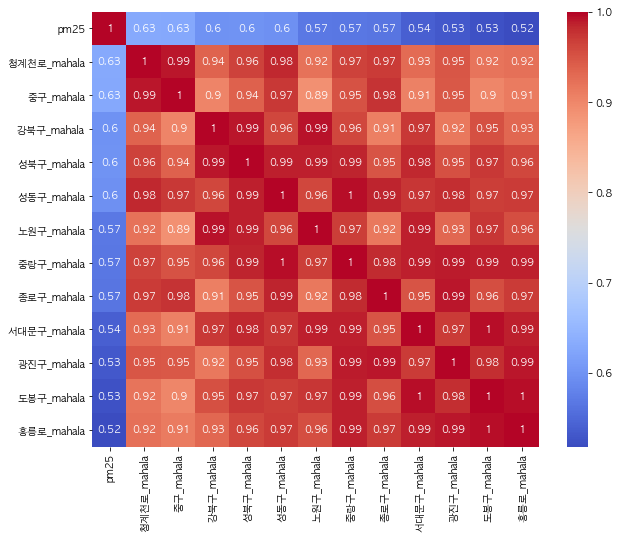

In [41]:
sns.heatmap(mahal1_corr, annot=True, cmap='coolwarm')
plt.show()

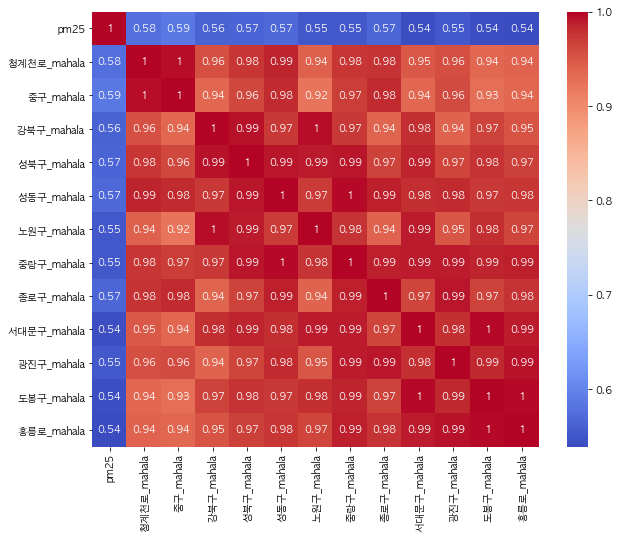

In [42]:
sns.heatmap(mahal2_corr,  annot=True, cmap='coolwarm')
plt.show()

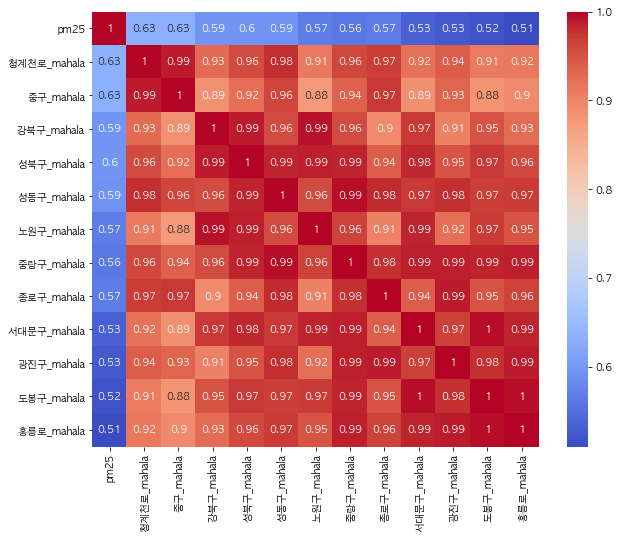

In [43]:
sns.heatmap(mahal3_corr,  annot=True, cmap='coolwarm')
plt.show()

## 5-Regression 예측 

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [49]:
def train_lr(df, y_col):
    
    y_target = df["pm25"]
    X_data = df.drop(["pm25"], axis=1, inplace=False)

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3,
                                                   random_state=1)

    
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_preds = lr.predict(X_test)
    mae = mean_absolute_error(y_test, y_preds)
    mape = mean_absolute_percentage_error(y_test, y_preds)*100
    print("***Linear Regression***")
    print('Intercept:', lr.intercept_)
    print('Coefficient:', lr.coef_)
    print("MAE", mae)
    print("MAPE", mape)
    
    #Actual vs Predicted
    c = [i for i in range(0,len(y_test),1)]
    fig = plt.figure(figsize=[10, 5])
    plt.plot(c, y_test, color="blue")
    plt.plot(c, y_preds, color="red")
    fig.suptitle('Actual and Predicted', fontsize=10)
    
    # Error terms
    c = [i for i in range(0,len(y_test),1)]
    fig = plt.figure(figsize=[10, 5])
    plt.plot(c, y_test-y_preds, color="blue")
    fig.suptitle('Error Terms', fontsize=10)
    plt.xlabel('Index', fontsize=10)                    
    plt.ylabel('ytest-ypred', fontsize=10)         


***Linear Regression***
Intercept: 15.274572824984098
Coefficient: [  0.5559145   13.71289189 -10.36558609  -3.21067863  21.98189339
   3.77453528  -3.83017966  -7.23936016 -11.0896166  -28.52461722
  28.20515566   1.38008467]
MAE 12.790878534813364
MAPE 101.56535327681758


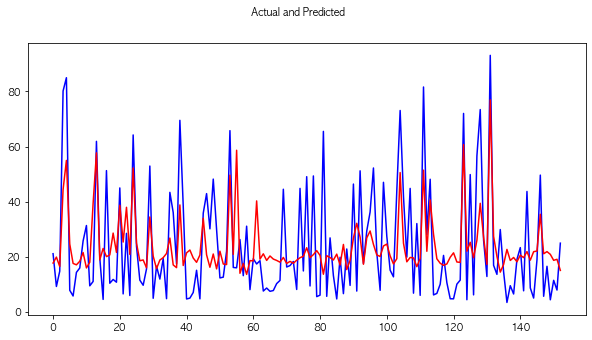

/Users/nowave/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nowave/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


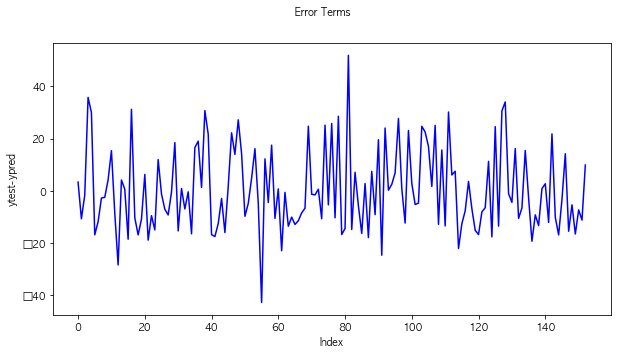

In [50]:
train_lr(mahal1_df, "pm25")

***Linear Regression***
Intercept: 14.068666944807472
Coefficient: [  5.23587298  12.91527018  -4.64070383 -17.51976765  27.77658995
  -5.88967684  -9.58664337   1.10173735   6.90534293 -43.25751914
  23.14384542   9.55944421]
MAE 14.776012158019967
MAPE 105.86521947618365


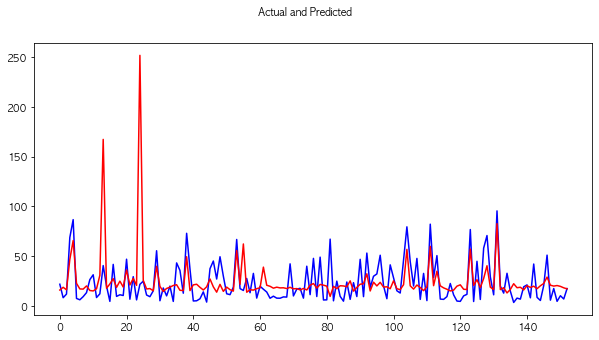

/Users/nowave/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nowave/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


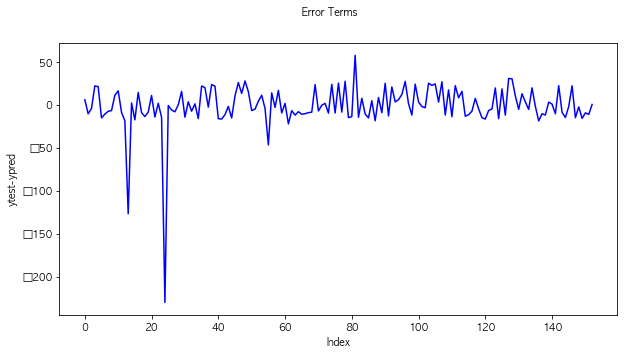

In [51]:
train_lr(mahal2_df, "pm25")

***Linear Regression***
Intercept: 14.474134668798847
Coefficient: [ -0.60072333  12.84569489 -11.30460953  -0.20099787  29.0783365
   4.3646757  -19.47917433   1.56884994  -3.89124615 -36.75333008
  14.0776014   16.38105421]
MAE 13.73141092509787
MAPE 102.75973055753056


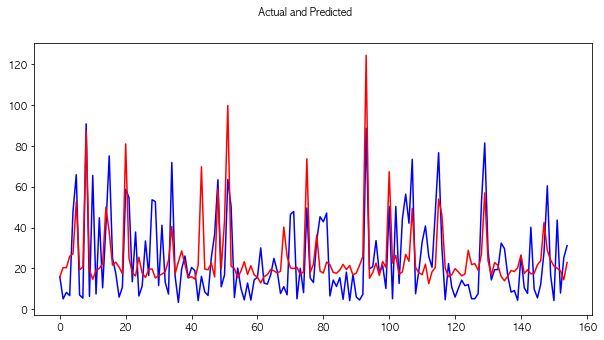

/Users/nowave/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nowave/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


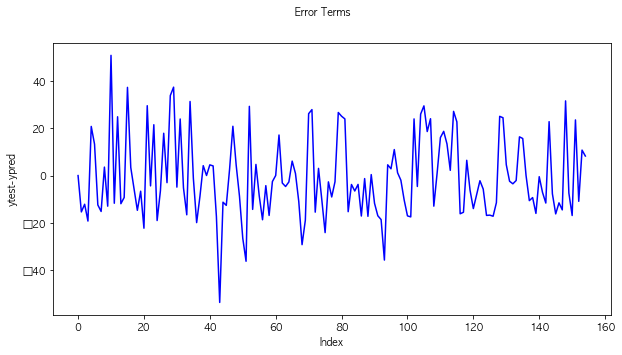

In [52]:
train_lr(mahal3_df, "pm25")